In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-07-19 14:13:44.422771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and a saturated signal qc, then extracting their corresponding gene label
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the filtered genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.044344,-1.318725,-2.020148,-0.554069,0.011276,-0.829771,-2.862801,-0.937871,-0.029335,-0.079737,...,-0.171958,-0.408107,-0.295392,-1.181492,-0.158178,0.011724,0.134771,-0.202173,-0.251086,-0.257935
1,-1.010345,-1.084419,-1.768553,-0.561297,-0.323891,-0.822472,-2.610682,-0.896614,-0.009458,-0.095426,...,-0.729691,-0.589988,-0.358002,-0.952563,0.049743,-0.022304,-0.315429,-0.437890,-0.758958,-0.282723
2,-0.264528,-1.164834,-1.780863,-0.491005,0.132880,-0.774631,-1.938029,-1.241575,-0.086820,-0.015274,...,-1.056200,-0.852987,-0.413210,-1.052634,0.117768,0.219654,-0.375627,-0.064497,-0.934184,-0.203839


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.210754,-1.321157,-2.145946,-0.151770,-0.155471,-0.775024,-2.385527,-1.495634,-0.418926,-0.075728,...,-0.499942,-0.513059,-0.424530,-1.244153,0.015781,0.078829,-0.196167,-0.524460,-1.037056,-0.314540
1,-0.126822,-1.382013,-2.173479,-0.208718,0.161889,-0.884878,-2.025593,-1.293933,-0.018025,0.045924,...,-0.736620,-0.432284,-0.507320,-1.781393,0.026585,0.059345,0.072144,0.047436,-0.541746,-0.602892
2,-0.387433,-1.079072,-2.346600,-0.331100,-0.102896,-0.669190,-2.169554,-0.808801,0.114080,-0.072095,...,-0.607937,-0.741635,-0.450178,-1.243914,-0.092732,0.055465,-0.369650,-0.256188,-0.590345,-0.260363


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to 
# learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=49,
    batch_size=80,
    encoder_batch_norm=True,
    epochs=255, 
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-07-19 14:13:52.742052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 14:13:52.929504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 14:13:52.929694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 14:13:52.930653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

In [10]:
# training the beta VAE
# ideally loss and val_loss are both small and similar in value
# if validation appears to start increasing after reaching values near the trainging curve, try lowering the epochs to finish prior to the start of overfitting
# a decreasing Kullback-Leibler divergence score suggests a better trained model
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/255


2023-07-19 14:13:56.209975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-19 14:13:56.243032: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f84a8005480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 14:13:56.243048: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-07-19 14:13:56.271226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 14:13:56.486909: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 3s 19ms/step - loss: 1821.5405 - recon: 1797.3937 - kl: 24.1468 - val_loss: 16441.4316 - val_recon: 14327.0752 - val_kl: 2114.3574
Epoch 2/255
10/10 [==============================] - 0s 4ms/step - loss: 958.9384 - recon: 934.5214 - kl: 24.4169 - val_loss: 25075.0039 - val_recon: 23222.5742 - val_kl: 1852.4277
Epoch 3/255
10/10 [==============================] - 0s 4ms/step - loss: 674.9826 - recon: 649.7962 - kl: 25.1864 - val_loss: 11299.6104 - val_recon: 10564.5537 - val_kl: 735.0565
Epoch 4/255
10/10 [==============================] - 0s 4ms/step - loss: 574.5955 - recon: 549.1955 - kl: 25.4000 - val_loss: 14279.7129 - val_recon: 13794.9619 - val_kl: 484.7501
Epoch 5/255
10/10 [==============================] - 0s 4ms/step - loss: 485.5341 - recon: 460.1118 - kl: 25.4222 - val_loss: 10109.5049 - val_recon: 9802.5586 - val_kl: 306.9466
Epoch 6/255
10/10 [==============================] - 0s 4ms/step - loss: 439.7661 - recon: 413.9859 - kl: 25

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add_loss
.........vars
......add_metric
........._metrics
............mean
...............vars
..................0
..................1
.........vars
......add_metric_1
........._metrics
............mean
...............vars
..................0
..................1
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............batch_normalization
...............vars
..................0
..................1
..................2
..................3
............batch_normalization_1
...............vars
..................0
..................1
..................2
..................3
............dense
...............vars
..................0
..................1
............dense_1
...............vars
..................0
..................1
............lambda
...............vars
.........vars
......functional_1
.........layers
........

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

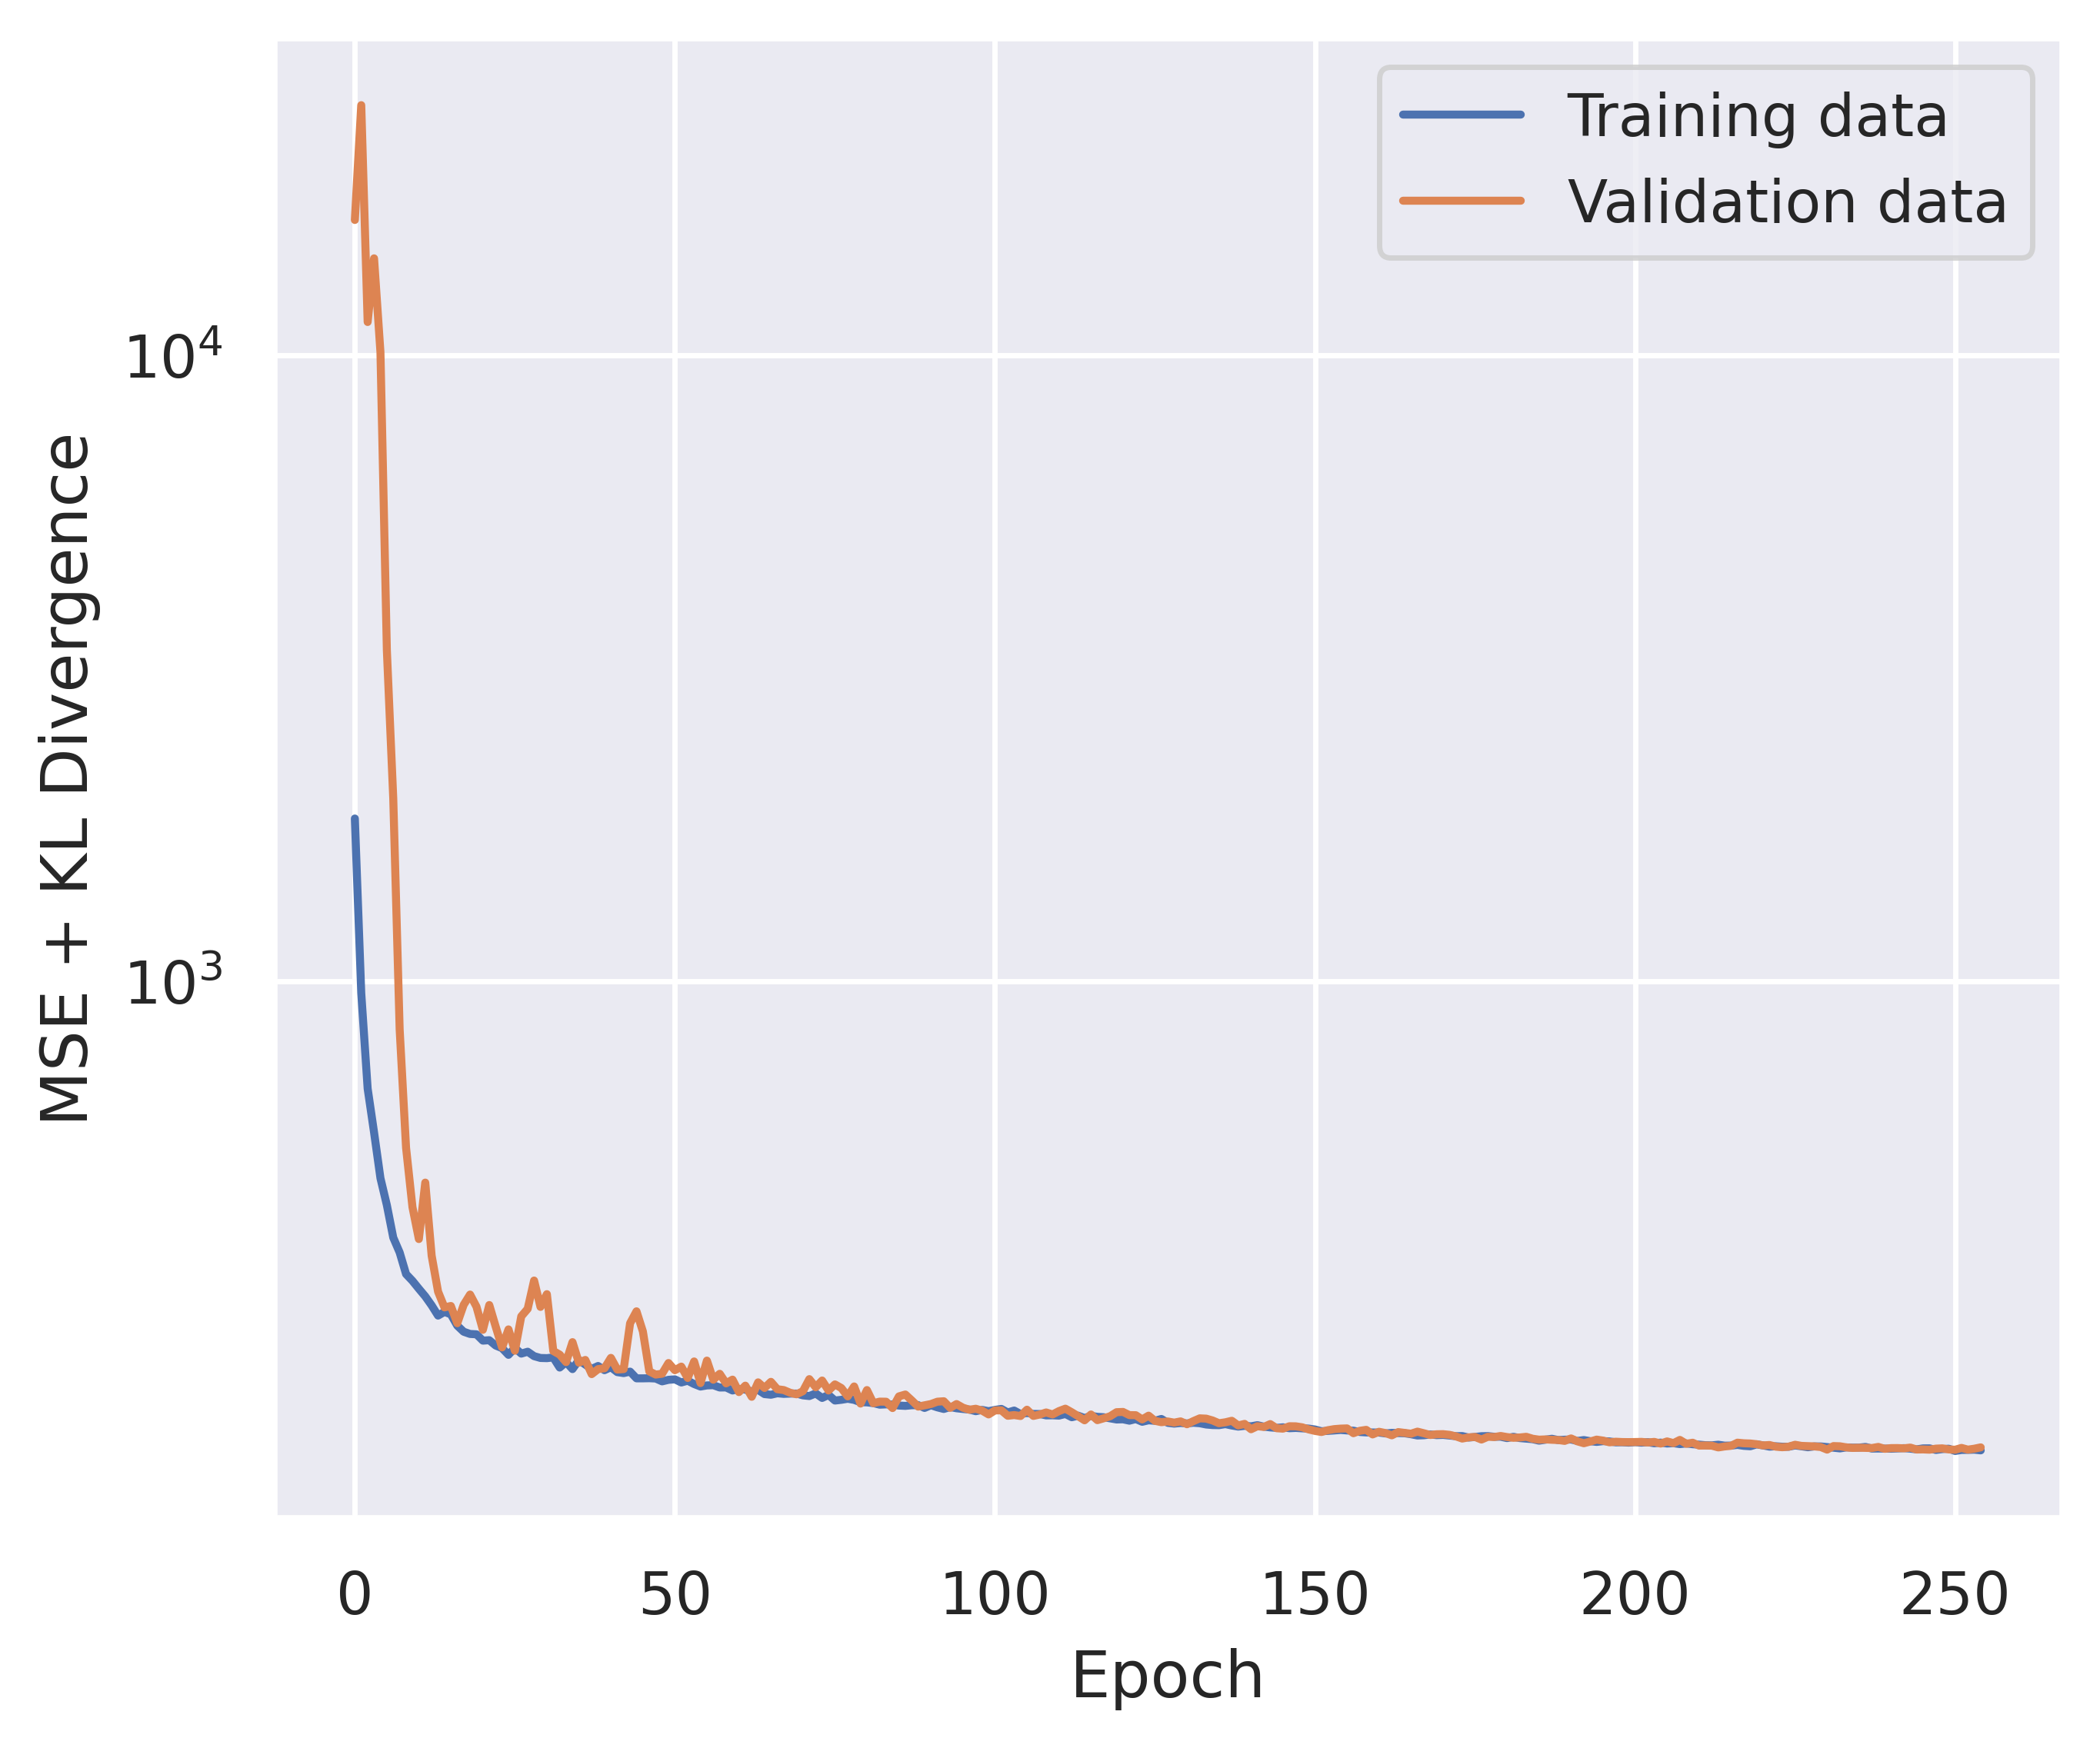

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene effect data with sex, AgeCategory, and ModelID for use in later t-tests
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001549,Adult,Male,train
1,ACH-001992,Adult,Male,train
2,ACH-000035,Adult,Male,train
3,ACH-000911,Adult,Male,train
4,ACH-000259,Pediatric,Female,train
...,...,...,...,...
907,ACH-000858,Adult,Male,test
908,ACH-000514,Adult,Male,test
909,ACH-000258,Adult,Female,test
910,ACH-002446,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 0s 694us/step


,ModelID,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
0,ACH-001549,-0.433536,-0.313002,0.106170,1.740107,0.051796,-0.092048,1.506002,-0.139188,1.185854,...,0.090623,-1.028285,0.596689,0.983311,2.057045,0.656402,0.335536,1.184920,0.809752,0.036602
1,ACH-001992,0.419395,0.565882,1.796919,-0.604782,1.892967,-0.170275,-0.377951,1.432515,-0.864623,...,1.425062,0.314461,2.994100,-0.368800,-0.018234,-1.465446,0.496746,0.427367,0.355352,1.249617
2,ACH-000035,0.732861,0.875819,-0.267913,1.066067,-0.391314,-0.501940,-1.188963,-0.868845,1.153341,...,0.535331,-2.002621,-0.183520,-0.247654,-0.957025,1.247603,1.202215,-0.729810,0.148200,0.842648
3,ACH-000911,0.678888,-0.606411,1.286772,-1.190569,-0.675025,1.643442,-0.169562,0.342549,-0.373929,...,0.133425,-0.908985,0.071771,-1.049606,1.250782,-0.244805,-0.322522,0.830723,-0.090198,-0.236837
4,ACH-000259,0.476313,0.367266,1.346829,0.106499,0.101344,0.814611,2.907445,0.997259,1.303916,...,-0.302948,1.337505,0.344960,1.044820,-0.602159,-0.835711,-1.958224,-0.292943,0.115363,1.033674


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-0.038390,-0.010072,0.031175,-0.075533,0.147331,-0.008982,0.052985,-0.015245,-0.079500,0.008005,...,-0.036216,0.036293,-0.016212,-0.093938,0.030863,-0.003590,0.006323,0.007708,-0.020439,-0.008556
1,0.061055,-0.041610,0.013261,-0.021186,-0.000131,-0.074913,0.020564,0.069120,0.026609,-0.007725,...,0.004073,-0.006511,-0.023371,-0.005856,-0.021866,0.012609,0.005722,0.012721,-0.033651,0.012131
2,0.003446,-0.061648,0.016866,-0.082559,0.063057,-0.008855,-0.023239,-0.027252,-0.096719,0.083446,...,-0.027031,-0.039182,-0.053009,-0.093481,0.004291,-0.046227,0.006410,-0.070168,-0.013231,0.012959
3,-0.054095,0.004926,-0.055859,-0.010414,0.040705,0.030561,0.093116,-0.055641,-0.011852,0.020742,...,-0.008818,0.077715,0.003448,-0.049125,-0.054797,-0.080224,-0.024841,0.076140,-0.056244,-0.042099
4,-0.021163,0.025108,-0.054590,-0.031431,0.049623,-0.021309,-0.023290,-0.057167,-0.012089,-0.006595,...,-0.032671,-0.049985,-0.093279,-0.012201,-0.012458,-0.021575,0.008027,-0.047325,-0.039885,-0.052858


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,AAAS,-0.038390,-0.010072,0.031175,-0.075533,0.147331,-0.008982,0.052985,-0.015245,-0.079500,...,-0.036216,0.036293,-0.016212,-0.093938,0.030863,-0.003590,0.006323,0.007708,-0.020439,-0.008556
1,AAMP,0.061055,-0.041610,0.013261,-0.021186,-0.000131,-0.074913,0.020564,0.069120,0.026609,...,0.004073,-0.006511,-0.023371,-0.005856,-0.021866,0.012609,0.005722,0.012721,-0.033651,0.012131
2,AARS1,0.003446,-0.061648,0.016866,-0.082559,0.063057,-0.008855,-0.023239,-0.027252,-0.096719,...,-0.027031,-0.039182,-0.053009,-0.093481,0.004291,-0.046227,0.006410,-0.070168,-0.013231,0.012959
3,AARS2,-0.054095,0.004926,-0.055859,-0.010414,0.040705,0.030561,0.093116,-0.055641,-0.011852,...,-0.008818,0.077715,0.003448,-0.049125,-0.054797,-0.080224,-0.024841,0.076140,-0.056244,-0.042099
4,AASDHPPT,-0.021163,0.025108,-0.054590,-0.031431,0.049623,-0.021309,-0.023290,-0.057167,-0.012089,...,-0.032671,-0.049985,-0.093279,-0.012201,-0.012458,-0.021575,0.008027,-0.047325,-0.039885,-0.052858
